In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import math
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

### Генерация сетки

In [26]:
def generate_mesh(r_min, r_max, I):
    
    r = np.zeros(I + 2)
    h = (r_max - r_min) / I
    for i in range(0, I + 2):
        r[i] = r_min + (i - 0.5) * h
        
    return r, h

### Вычисление функций и производных из задачи 1

In [27]:
def v0(r):
    
    top = 2 * r - (a + b)
    bottom = (b - a) ** 2 - top ** 2
    result = np.where((a < r) & ( r < b), np.exp(-4 * top ** 2 / bottom), 0)
    
    return result

In [28]:
def dv0(r):
    #dv0/dr в точке r
    top = 2 * r - (a + b)
    bottom = (b - a) ** 2 - top ** 2
    exp_term = np.exp(-4 * top ** 2 / bottom)
    result = np.where((a < r) & (r < b), 
                      (-16 * top ** 3 / bottom ** 2 - 16 * top / bottom) * exp_term,
                      0)
    return result

## Задача 4

In [29]:
def U(r):
    return v0(r)

In [30]:
def dU(r):
    return dv0(r)

In [31]:
def u1__(r, t):

    return r ** ((1 - d) / 2)  * U(c * t - r)

In [32]:
def du1__(r, t):
    return (1 - d)/2 * r ** (-(1 + d) / 2) * U(c * t - r) - r ** ((1 - d) / 2) * dU(c * t - r)

In [33]:
def f(r, t):
    return (c ** 2) * (d - 1) * (d - 3) * U(c * t - r) / (4 * r ** ((d + 3) / 2))

### Параметры

In [34]:
r_min = 0.1
r_max = 1.8
a = 0.6
b = 1.2
c = 1.5
d = 1

In [35]:
I_initial = 100
T = 1.6
C = 0.5
t_initial = 1

In [36]:
h_initial = (r_max - r_min) / I_initial
tau_initial = C * (h_initial / c)
steps = math.ceil(T / tau_initial)
times = np.array([t_initial + n * tau_initial for n in range(steps + 1)])

### Схема

In [37]:
def solver(r_max, r_min, C, c, T, a_coeff, alpha):

    k = len(a_coeff)
    h = h_initial * alpha[0]
    N = int(steps / alpha[1])
    I = int(I_initial / alpha[0])
    tau = tau_initial * alpha[1]

    times = np.array([t_initial + n * tau for n in range(N + 1)])
    r, _ = generate_mesh(r_min, r_max, I)
    size = times[1:-1].shape[0]
    
    u = np.zeros((N + 1, I + 2))
    u[0] = u1__(r, times[0])   
    u[1] = u1__(r, times[1]) 

    for n in range(1, size):
        sum1 = np.zeros_like(u[0, k - 1:I + 3 - k]) 
        for i in range(k):
            sum1 += a_coeff[i] * (u[n, k - 1 - i:I + 3 - k - i] + u[n, k - 1 + i:I + 3 - k + i])
        u_without_borders = 2 * u[n, k - 1:I + 3 - k] - u[n - 1, k - 1:I + 3 - k] + (tau * c) ** 2 / h ** 2 * sum1
        u[n + 1] = np.append(np.append(np.full(k - 1, u_without_borders[0]), u_without_borders), np.full(k - 1, u_without_borders[-1]))
        
    row_step = int(N / steps)  
    col_step = int(I / I_initial)
    
    row_indices = np.arange(row_step, N - row_step + 1, row_step)
    col_indices = np.arange(col_step // 2 + 1, I - col_step // 2 + 1, col_step)

    return u[row_indices, :][:, col_indices]

In [38]:
def compute_error(numerical, analytical):
    return np.max(np.abs(numerical - analytical))

In [39]:
def calculate_norms(u1, u2, u3):

    C_arr = []; L2_arr = []
    for i in range(u1.shape[0]):
        diff1 = abs(u1[i] - u2[i])
        diff2 = abs(u2[i] - u3[i])
        C = np.linalg.norm(diff1, ord=np.inf) / np.linalg.norm(diff2, ord=np.inf)
        L2 = np.linalg.norm(diff1, ord=2) / np.linalg.norm(diff2, ord=2)
        C_arr.append(C); L2_arr.append(L2)
    
    return C_arr, L2_arr

In [40]:
def calculate_for_meshes(a_arr, alphas):
    solutions = []
    for alpha in alphas:
        u = solver(r_max, r_min, C, c, T, a_arr, alpha)
        solutions.append(u)

    return solutions

### Схема O42, R1

In [41]:
alphas = [(num, pow(num, 2)) for num in [1, 1/3, 1/9]]
a_arr = [-5/4, 4/3, -1/12]

In [42]:
solutions = calculate_for_meshes(a_arr, alphas) 
u1_, u2_, u3_ = solutions[0], solutions[1], solutions[2]

In [43]:
C, L2 = calculate_norms(u1_, u2_, u3_)

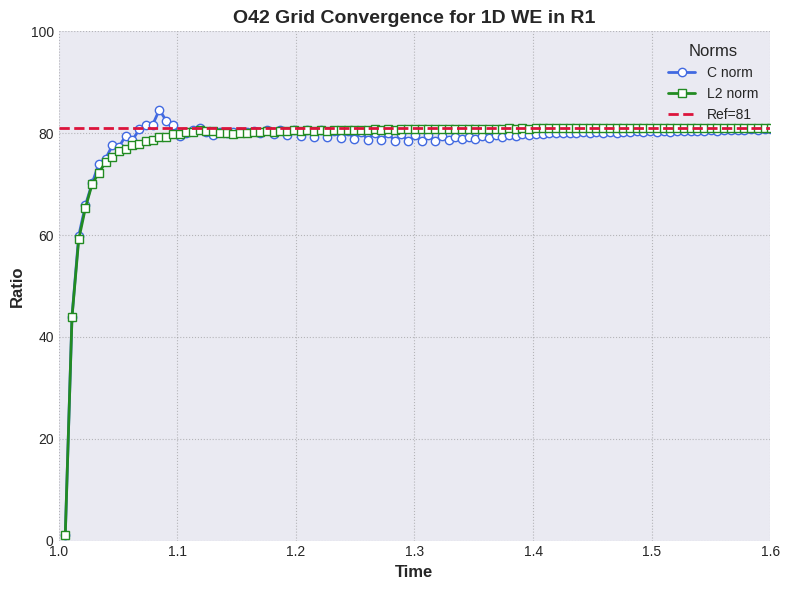

In [44]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))  
ax.set_ylim(0, 100)
ax.set_xlim(1, 1.6)
coeff = 0
ax.plot(times[(coeff + 1):-1], C, label='C norm', color='royalblue', linewidth=2, marker='o', markersize=6, markerfacecolor='white')
ax.plot(times[(coeff + 1):-1], L2, label='L2 norm', color='forestgreen', linewidth=2, marker='s', markersize=6, markerfacecolor='white')
ax.axhline(y=81,label="Ref=81", color='crimson', linestyle='--', linewidth=2)

ax.grid(True, linestyle=':', color='gray', alpha=0.5)
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Ratio", fontsize=12, fontweight='bold')
ax.set_title(f"O42 Grid Convergence for 1D WE in R{d}", fontsize=14, fontweight='bold')


ax.legend(loc='upper right', fontsize=10, frameon=False, title="Norms", title_fontsize=12)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()  
plt.savefig('Grid_convergence_O42_R1.png')
plt.show()

### Схема O62, R1

In [45]:
alphas = [(num, pow(num, 3)) for num in [1, 1/3, 1/9]]
a_arr = [-49/36, 3/2, -3/20, 1/90]

In [46]:
solutions = calculate_for_meshes(a_arr, alphas) 
u1_, u2_, u3_ = solutions[0], solutions[1], solutions[2]

In [47]:
C, L2 = calculate_norms(u1_, u2_, u3_)

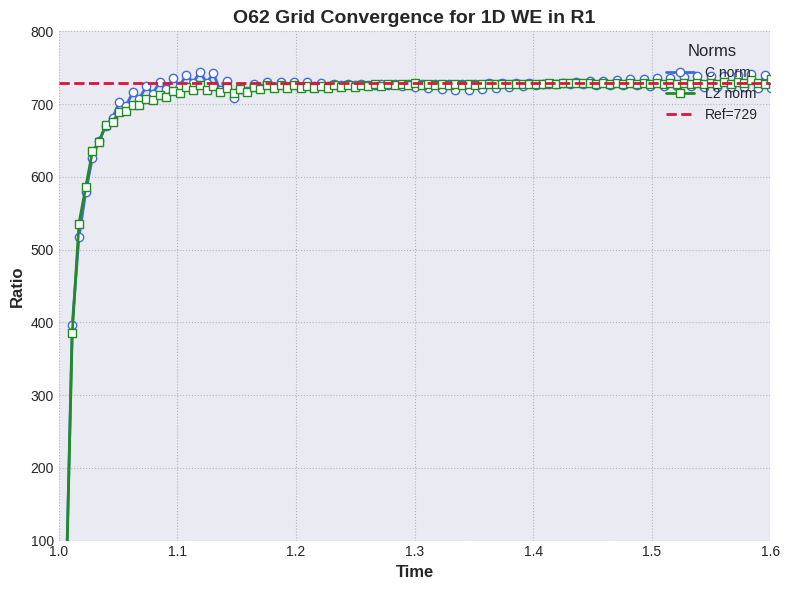

In [48]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))  
ax.set_ylim(100, 800)
ax.set_xlim(1, 1.6)
coeff = 0
ax.plot(times[(coeff + 1):-1], C, label='C norm', color='royalblue', linewidth=2, marker='o', markersize=6, markerfacecolor='white')
ax.plot(times[(coeff + 1):-1], L2, label='L2 norm', color='forestgreen', linewidth=2, marker='s', markersize=6, markerfacecolor='white')
ax.axhline(y=729,label="Ref=729", color='crimson', linestyle='--', linewidth=2)

ax.grid(True, linestyle=':', color='gray', alpha=0.5)
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Ratio", fontsize=12, fontweight='bold')
ax.set_title(f"O62 Grid Convergence for 1D WE in R{d}", fontsize=14, fontweight='bold')


ax.legend(loc='upper right', fontsize=10, frameon=False, title="Norms", title_fontsize=12)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()  
plt.savefig('Grid_convergence_O62_R1.png')
plt.show()